In [1]:
%matplotlib notebook
import numpy as np
import glob, os, copy
from astropy.io import fits
from matplotlib import pyplot as plt
import time
from scipy.optimize import minimize
from scipy.stats import truncnorm
import emcee
import corner
from IPython.display import display, Math
from sklearn.neighbors import KernelDensity

In [2]:
# ----- Structures ----- #
current_dir = os.getcwd()
dir_SFH = '/data/jlee/DATA/Tests/test_python/SFH_isjang/SFH_test/'
dir_obs = dir_SFH+'obs/'
dir_mod = dir_SFH+'models/'

In [3]:
# ----- Loading data ----- #

# The observed CMD
obs_cmd = fits.getdata(dir_obs+'F456.fits', header=False)
Y = obs_cmd.copy()
Y_sum = np.sum(Y)
S = np.sqrt(Y)
S[S==0] = 1.    # not this, but just placeholder
# S = np.sqrt(S**2 + detection_error**2 + minimal_error**2)
Y = Y/Y_sum
S = S/Y_sum
Y_shape = Y.shape

# Model CMDs ([Fe/H] = -1.50, -1.60, -1.70)
model_list = glob.glob(dir_mod+'a*fehm1.60.fits')
model_list = sorted(model_list)
n_model = len(model_list)
Xm = np.zeros((n_model, Y_shape[0], Y_shape[1]))
for k in np.arange(n_model):
    mod_cmd = fits.getdata(model_list[k], header=False)
    fac = 1 / np.sum(mod_cmd)
    Xm[k, :, :] = fac*mod_cmd

In [4]:
model_list

['/data/jlee/DATA/Tests/test_python/SFH_isjang/SFH_test/models/a07.00fehm1.60.fits',
 '/data/jlee/DATA/Tests/test_python/SFH_isjang/SFH_test/models/a08.00fehm1.60.fits',
 '/data/jlee/DATA/Tests/test_python/SFH_isjang/SFH_test/models/a09.00fehm1.60.fits',
 '/data/jlee/DATA/Tests/test_python/SFH_isjang/SFH_test/models/a10.00fehm1.60.fits']

In [5]:
# ----- Model functions ----- #
wlim_lo, wlim_hi = 1.0e-3, 1.0e+5
plim_lo, plim_hi = np.log10(wlim_lo), np.log10(wlim_hi)

def model_linpar(*theta, llim=wlim_lo, ulim=wlim_hi):
    for i in np.arange(n_model):
        x = Xm[i,:,:]
        tx = np.where(theta[i] > llim, theta[i]*x, 0.*x) 
        tx = np.where(theta[i] < ulim, tx, ulim*x) 
        if (i == 0):
            out = tx
        else:
            out += tx
    return out

def model_logpar(*theta):
    t = 10.**(np.array(theta))
    return model_linpar(*t)

def log_likelihood(model, y, yerr, *theta):
    nll = 0.5*np.sum(((y-model(*theta))/yerr)**2. + 2.*np.log(yerr)) + 0.5*len(y)*np.log(2.*np.pi)
    return -nll

def log_prior(*theta, llim=wlim_lo, ulim=wlim_hi):
    if (np.any((np.array(theta) < llim) | (np.array(theta) > plim_hi)) == True):
        return -np.inf
    else:
        return 0.

def log_posterior(model, y, yerr, *theta):
    return log_prior(*theta) + log_likelihood(model, y, yerr, *theta)

In [6]:
# ----- Maximum likelihood method for initial guess ----- #
nll = lambda x: -log_likelihood(model_logpar, Y, S, *x)
initial = [0]*n_model
soln = minimize(nll, initial)

In [7]:
soln

      fun: -9157.368684634674
 hess_inv: array([[ 1.44202932e+00,  1.25700619e+00,  8.62739026e-03,
        -6.66874323e-03],
       [ 1.25700619e+00,  1.09636047e+00,  7.66181992e-03,
        -5.84410179e-03],
       [ 8.62739026e-03,  7.66181992e-03,  1.15494394e-03,
        -6.31311865e-04],
       [-6.66874323e-03, -5.84410179e-03, -6.31311865e-04,
         6.02336226e-04]])
      jac: array([0.        , 0.        , 0.        , 0.00036621])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 331
      nit: 37
     njev: 55
   status: 2
  success: False
        x: array([-3.15057853, -3.01606546, -1.47076329, -0.22270569])

In [8]:
clipped_sol = copy.deepcopy(soln.x)
clipped_sol[clipped_sol < plim_lo] = -np.inf

In [9]:
clipped_sol

array([       -inf,        -inf, -1.47076329, -0.22270569])

<IPython.core.display.Javascript object>


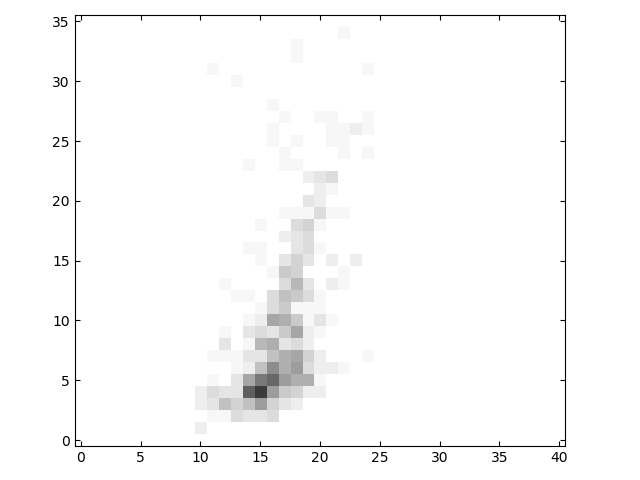

In [10]:
fig, ax = plt.subplots()
ax.imshow(Y, origin='lower', vmin=0., vmax=0.05, cmap='gray_r')
fig.tight_layout()

<IPython.core.display.Javascript object>


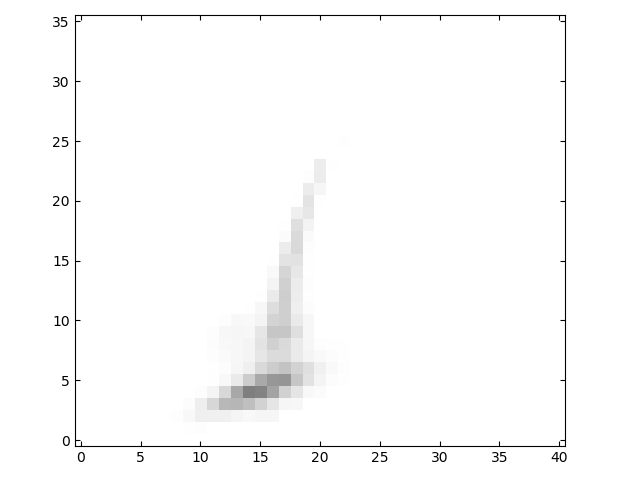

In [11]:
fig, ax = plt.subplots()
ax.imshow(model_logpar(*clipped_sol), origin='lower', vmin=0., vmax=0.05, cmap='gray_r')
fig.tight_layout()

<IPython.core.display.Javascript object>


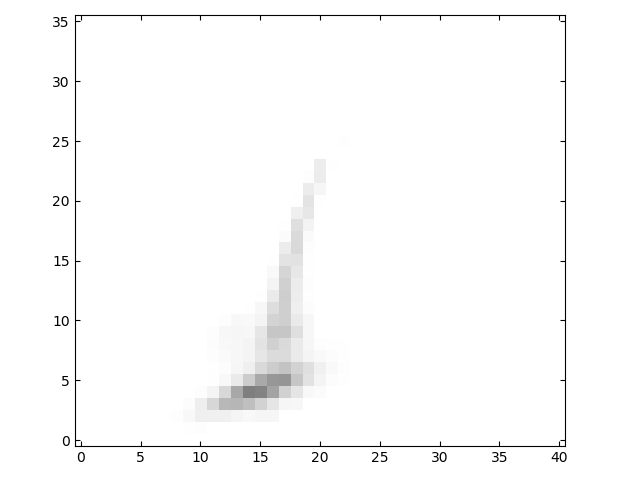

In [12]:
fig, ax = plt.subplots()
ax.imshow(model_logpar(*soln.x), origin='lower', vmin=0., vmax=0.05, cmap='gray_r')
fig.tight_layout()

In [13]:
log_prob = lambda x: log_posterior(model_linpar, Y, S, *x)

nwalkers, ndim = 32, n_model
# pos = soln.x + 1.0*np.random.randn(nwalkers, ndim)
init = [10.**(ix) if ix > plim_lo else wlim_lo for ix in soln.x]
pos = np.zeros((nwalkers, ndim))
for i in range(ndim):
    pos[:,i] = ((lambda m, s, l, u: truncnorm((l-m)/s, (u-m)/s, loc=m, scale=s))
                (init[i], 1.0e-2, plim_lo, plim_hi)).rvs(nwalkers)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob)

In [14]:
start_time = time.time()
sampler.run_mcmc(pos, 1000, progress=True);
print("----- running time : {0:.3f} sec".format(time.time()-start_time))

  0%|          | 0/1000 [00:00<?, ?it/s]/home/jlee/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 1000/1000 [00:06<00:00, 146.66it/s]

----- running time : 6.833 sec


<IPython.core.display.Javascript object>


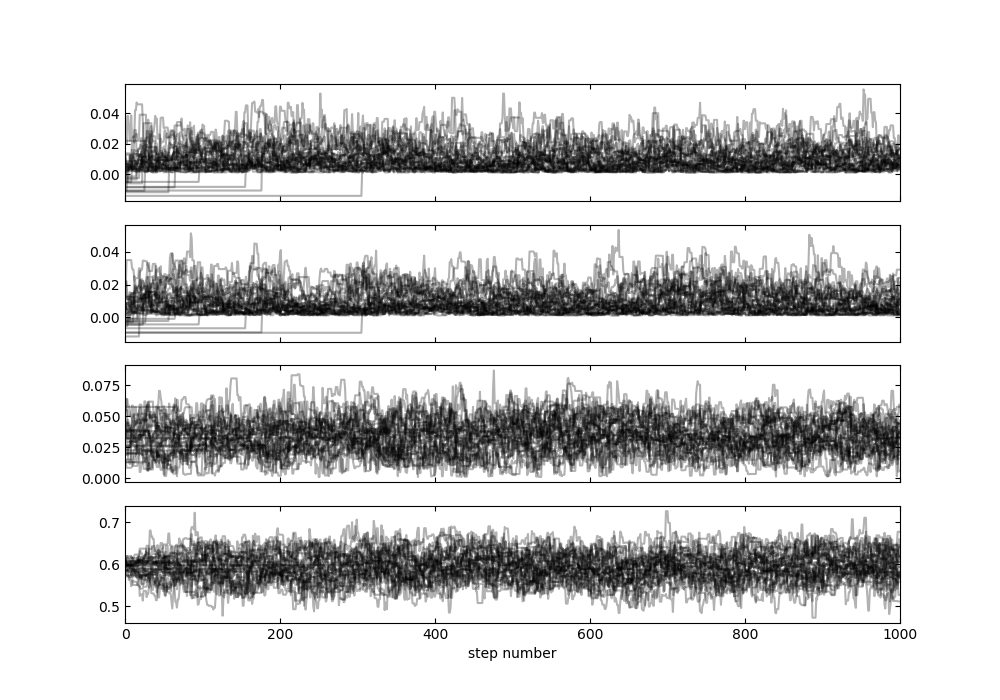

In [15]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)

samples = sampler.get_chain()
labels = ['par'+str(j+1) for j in np.arange(n_model)]

for i in np.arange(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
axes[-1].set_xlabel("step number");

<IPython.core.display.Javascript object>


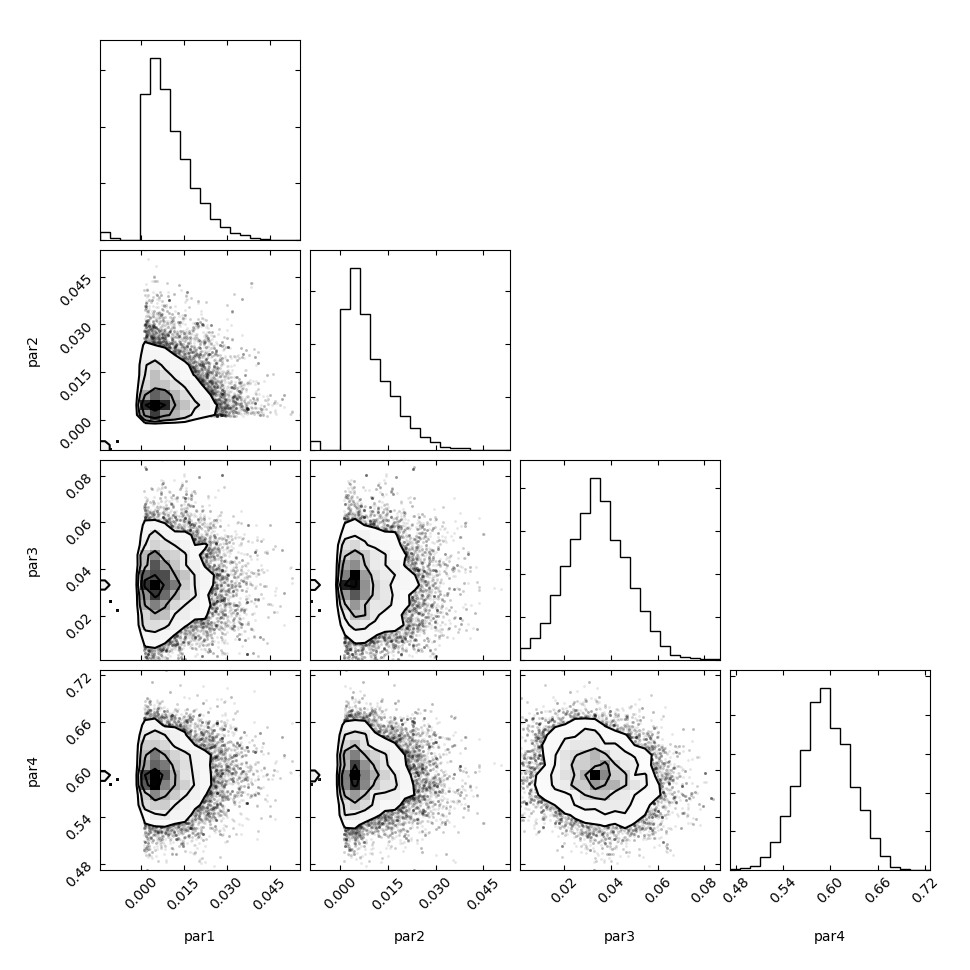

In [16]:
flat_samples = sampler.get_chain(discard=100, flat=True)
flat_samples.shape

fig = corner.corner(flat_samples, labels=labels, truths=[*soln.x]);

In [17]:
popt, perr_hi, perr_lo, perr = [], [], [], []
for i in np.arange(ndim):
    mcmc = np.percentile(flat_samples[:, i], [50-34.15, 50, 50+34.15])
    q = np.diff(np.array([mcmc[0], mcmc[1], mcmc[2]]))
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))
    
    popt.append(mcmc[1])
    perr_hi.append(mcmc[2]-mcmc[1])
    perr_lo.append(mcmc[1]-mcmc[0])
    perr.append(0.5*(mcmc[2]-mcmc[0]))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Javascript object>


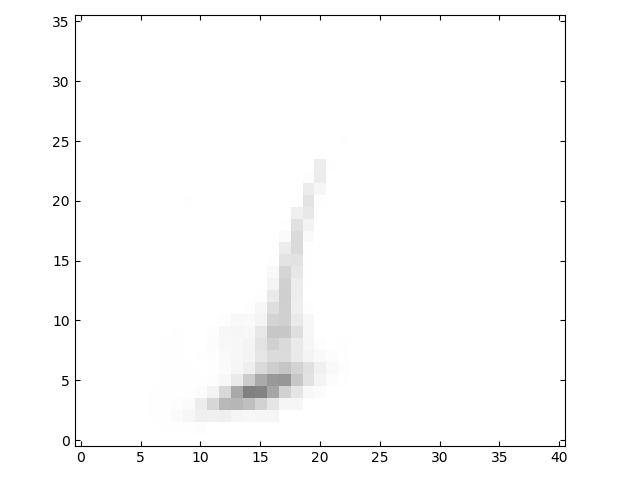

In [18]:
fig, ax = plt.subplots()
ax.imshow(model_linpar(*popt), origin='lower', vmin=0., vmax=0.05, cmap='gray_r')
fig.tight_layout()